In [2]:
import pandas as pd
import os
from datetime import datetime
import re

In [3]:
"""
def is_leaf_directory(directory):
    # Check if the directory contains no subdirectories
    return not any(os.path.isdir(os.path.join(directory, name)) for name in os.listdir(directory))

def rename_files(root_dir):
    for root, dirs, files in os.walk(root_dir):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            if is_leaf_directory(dir_path):
                file_list = sorted(os.listdir(dir_path))
                if len(file_list) >= 2:
                    first_file = os.path.join(dir_path, file_list[0])
                    second_file = os.path.join(dir_path, file_list[1])
                    os.rename(first_file, os.path.join(dir_path, "controller.log"))
                    os.rename(second_file, os.path.join(dir_path, "camera.log"))

# Specify the root directory containing the nested directories
root_directory = "/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed"

# Call the function to rename files
rename_files(root_directory)
"""

'\ndef is_leaf_directory(directory):\n    # Check if the directory contains no subdirectories\n    return not any(os.path.isdir(os.path.join(directory, name)) for name in os.listdir(directory))\n\ndef rename_files(root_dir):\n    for root, dirs, files in os.walk(root_dir):\n        for dir_name in dirs:\n            dir_path = os.path.join(root, dir_name)\n            if is_leaf_directory(dir_path):\n                file_list = sorted(os.listdir(dir_path))\n                if len(file_list) >= 2:\n                    first_file = os.path.join(dir_path, file_list[0])\n                    second_file = os.path.join(dir_path, file_list[1])\n                    os.rename(first_file, os.path.join(dir_path, "controller.log"))\n                    os.rename(second_file, os.path.join(dir_path, "camera.log"))\n\n# Specify the root directory containing the nested directories\nroot_directory = "/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed"\n\n# Call the fu

In [4]:
def process_camera_log_mc(log_file_path):
    # Read the log file and split it into lines
    with open(log_file_path, "r") as file:
        lines = file.readlines()

    # Initialize lists to store parsed data
    pid_list = []
    start_timestamp_list = []
    afterfetch_timestamp_list = []
    afterhil_timestamp_list = []
    finish_timestamp_list = []

    if lines and "Camera started transmitting" in lines[0]:
        lines.pop(0)

    # Iterate through lines, parsing the relevant data
    for i in range(0, len(lines), 4):
        # Check if all four lines for an entity are present
        if i + 3 < len(lines):
            start_line = lines[i].split()
            afterfetch_line = lines[i + 1].split()
            afterhil_line = lines[i + 2].split()
            finish_line = lines[i + 3].split()
            
            # Check if all lines correspond to the same PID
            if (start_line[5] == afterfetch_line[5] == afterhil_line[5] == finish_line[5]) and \
               (start_line[0] == "[INFO]" and afterfetch_line[0] == "[INFO]" and afterhil_line[0] == "[INFO]" and finish_line[0] == "[INFO]"):
                pid = start_line[5]
                start_timestamp = int(start_line[7])
                afterfetch_timestamp = int(afterfetch_line[7])
                afterhil_timestamp = int(afterhil_line[7])
                finish_timestamp = int(finish_line[7])

                pid_list.append(pid)
                start_timestamp_list.append(start_timestamp)
                afterfetch_timestamp_list.append(afterfetch_timestamp)
                afterhil_timestamp_list.append(afterhil_timestamp)
                finish_timestamp_list.append(finish_timestamp)

    # Create a pandas DataFrame
    data = {
        "pid": pid_list,
        "start_timestamp": start_timestamp_list,
        "afterfetch_timestamp": afterfetch_timestamp_list,
        "afterhil_timestamp": afterhil_timestamp_list,
        "finish_timestamp": finish_timestamp_list
    }

    df = pd.DataFrame(data)

    # Convert timestamps to datetime objects
    df["start_timestamp"] = pd.to_datetime(df["start_timestamp"])
    df["afterfetch_timestamp"] = pd.to_datetime(df["afterfetch_timestamp"])
    df["afterhil_timestamp"] = pd.to_datetime(df["afterhil_timestamp"])
    df["finish_timestamp"] = pd.to_datetime(df["finish_timestamp"])

    return df

def process_controller_log_mc(log_file_path):
    # Read the log file and split it into lines
    with open(log_file_path, "r") as file:
        lines = file.readlines()

    # Initialize lists to store parsed data
    space_pid_list = []
    hand_pid_list = []
    space_timestamp_list = []
    hand_timestamp_list = []
    
    # Iterate through lines, parsing the relevant data
    for i in range(0, len(lines), 2):
        # Check if all four lines for an entity are present
        if i + 1 < len(lines):
            line1 = lines[i].split()
            line2 = lines[i + 1].split()
            # Check if all lines correspond to the same PID
            if (line1[3] in ("WORKSPACEHAND", "STARTSPACEHAND") and line2[3] in ["STARTSPACE", "WORKSPACE"]):
                space_pid = line1[5]
                hand_pid = line2[5]
                space_timestamp = int(line1[7])
                hand_timestamp = int(line2[7])

                space_pid_list.append(space_pid)
                hand_pid_list.append(hand_pid)
                space_timestamp_list.append(space_timestamp)
                hand_timestamp_list.append(hand_timestamp)
            elif(line2[3] in ("WORKSPACEHAND", "STARTSPACEHAND") and line1[3] in ["STARTSPACE", "WORKSPACE"]):
                space_pid = line2[5]
                hand_pid = line1[5]
                space_timestamp = int(line2[7])
                hand_timestamp = int(line1[7])

                space_pid_list.append(space_pid)
                hand_pid_list.append(hand_pid)
                space_timestamp_list.append(space_timestamp)
                hand_timestamp_list.append(hand_timestamp)    
                
    # Create a pandas DataFrame
    data = {
        "space_pid": space_pid_list,
        "hand_pid": hand_pid_list,
        "spacestate_receive": space_timestamp_list,
        "hil_receive": hand_timestamp_list,
    }

    df = pd.DataFrame(data)

    # Convert timestamps to datetime objects
    df["spacestate_receive"] = pd.to_datetime(df["spacestate_receive"])
    df["hil_receive"] = pd.to_datetime(df["hil_receive"])
    return df

def collect_multithreaded_controller_camera_process_avgs(root_dir, minuend, subtrahend):
    time_avg_list = []
    cnt_list = []
    frequence_list = []
    for subdir, dirs, files in os.walk(root_dir):
        camera_df = pd.DataFrame()
        controller_df = pd.DataFrame()
        for file in files:
            if len(files) != 2:
                print("ERROR AT "+ subdir)
            file_path = os.path.join(subdir, file)
            if file == "camera.log":
                camera_df = process_camera_log_mc(file_path)
            elif file == "controller.log":
                controller_df = process_controller_log_mc(file_path)
        records = pd.concat([camera_df, controller_df], axis=1,  join='inner')
        if records.empty:
            print("EMPTY DF AT " + subdir)
            continue
        
        records["t"] = records[minuend] - records[subtrahend]
        records["t"] = records["t"].astype(int)  // 10 ** 6
        
        # extract frequence
        pattern = r'^\d+(\.\d+)?'
        # Extracting the numeric part
        match = re.match(pattern, os.path.relpath(file_path, root_dir))
        frequence = float(match.group())
        
        time_avg_list.append(records["t"].mean())
        frequence_list.append(frequence)
        cnt_list.append(len(records))

        
    return pd.DataFrame({"time_avg": time_avg_list, "frequence": frequence_list, "cnt": cnt_list}).sort_values(by='frequence')



In [11]:
mt_dir = "/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed/multithreaded_controller/multithreaded"
st_dir = "/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed/multithreaded_controller/singlethreaded"

multithreaded_camera = collect_multithreaded_controller_camera_process_avgs(mt_dir, "finish_timestamp", "start_timestamp")
singlethreaded_camera = collect_multithreaded_controller_camera_process_avgs(st_dir, "finish_timestamp", "start_timestamp")
merged_df = pd.merge(singlethreaded_camera, multithreaded_camera, on='frequence', how='left',  suffixes=('_single', '_multi'))
merged_df

EMPTY DF AT /home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed/multithreaded_controller/multithreaded
EMPTY DF AT /home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed/multithreaded_controller/multithreaded/0.5sec
EMPTY DF AT /home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed/multithreaded_controller/singlethreaded


/home/szogabaha/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:134: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


,time_avg_single,frequence,cnt_single,time_avg_multi,cnt_multi
0,101.074766,0.01,107,95.564516,124.0
1,102.224719,0.03,356,90.975000,120.0
2,98.175000,0.05,360,100.728814,59.0
3,99.754902,0.07,102,112.253165,79.0
4,103.718690,0.10,519,116.194444,36.0
5,107.798742,0.20,159,132.100000,20.0
6,108.708738,0.40,103,NaN,NaN
7,108.505747,0.60,87,NaN,NaN
8,126.214286,0.80,28,NaN,NaN
9,120.658537,1.00,41,NaN,NaN


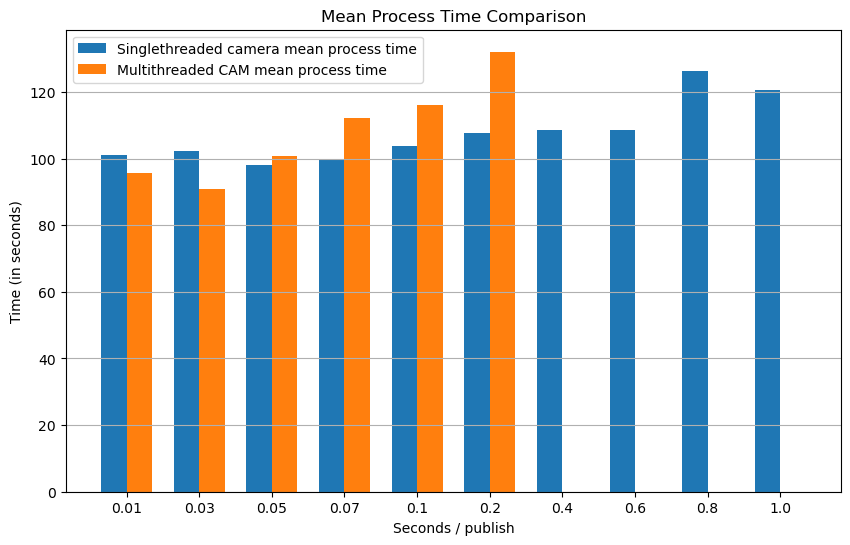

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace NaN values with 0
merged_df.fillna(0, inplace=True)

# Sort the DataFrame by 'frequence' column in decreasing order
merged_df_sorted = merged_df.sort_values(by='frequence', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))

# Define the width of each bar
bar_width = 0.35

# Define the x positions for the bars
index = merged_df_sorted.index

# Plot 'time_avg_single' column
plt.bar(index, merged_df_sorted['time_avg_single'], bar_width, label='Singlethreaded camera mean process time')

# Plot 'time_avg_multi' column
plt.bar(index + bar_width, merged_df_sorted['time_avg_multi'], bar_width, label='Multithreaded CAM mean process time')

# Set labels and title
plt.xlabel('Seconds / publish')
plt.ylabel('Time (in seconds)')
plt.title('Mean Process Time Comparison')
plt.xticks(index + bar_width / 2, merged_df_sorted['frequence'])  # Set x-tick labels
plt.legend()

# Show plot
plt.grid(axis="y")
plt.show()


In [10]:
df = process_camera_log_mc("/home/szogabaha/src/uu/thesis/software/hilcps_edge_computing/experiments/camera_speed/multithreaded_controller/singlethreaded/0.1sec/camera.log")
df2 = pd.DataFrame()
df2["start_to_fetch"] = (df["afterfetch_timestamp"] - df["start_timestamp"]).astype(int) // 10 ** 6
df2["fetch_to_hil"] = (df["afterhil_timestamp"] - df["afterfetch_timestamp"]).astype(int) // 10 ** 6
df2["hil_to_finish"] = (df["finish_timestamp"] - df["afterhil_timestamp"]).astype(int) // 10 ** 6
df2

/home/szogabaha/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/szogabaha/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  after removing the cwd from sys.path.
/home/szogabaha/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """


,start_to_fetch,fetch_to_hil,hil_to_finish
0,263,155,17
1,2,81,20
2,2,87,18
3,2,111,24
4,3,84,25
...,...,...,...
518,1,65,13
519,1,58,13
520,2,73,17
521,2,80,25
